## Pymaceutical Final Analysis

The project is a data analysis on the performance of ten drugs tested on mice. Panel data covers 45 days, where tumor development was observed and measured. The primary purpose is to compare the efficiency of Capomulin against the nine other drugs tested in the study. Initial data presents 249 mice; we dropped one mouse ID because two sets of data were present for the one mouse ID, leaving us with 248 unique specimens.
 
When running upper and lower bounds with quartiles, we* note that one observation in Infubinol sits below Infubinol's lower bound. The mouse ID   is c326 on day 5 of the study.

We could surmise limited correlative power between tumor size and mouse weight using the simple linear correlation value between tumor size and mouse weight. Still, I don't know if I ran the SLR for the assignment correctly. I reran it using a seaborn correlation matrix; aside from the binary encoding, that is more understandable as I also applied other columns for comparison.

In the correlation heatmap, we find that in a comparison of Capomulin and Placebo trials that there is a stronger correlation for Tumor Volume (mm3) ~ Weight (g) and Tumor Volume (mm3) ~ Drug_Enc. With that same data set of Capomulin versus Placebo, the MLR coefficient suggests a positive reaction to using Capomulin over a placebo. Ceteris paribus, placebo use adds 16.05 mm3 to tumor volume.

In [27]:
# Dependencies and calls
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

In [5]:
# Set data CSVs as path variables, call path as read_csv
mouse_csv = "Resources/Mouse_metadata.csv"
mouse_id_df = pd.read_csv(mouse_csv) 
study_csv = "Resources/Study_results.csv"
study_results_df = pd.read_csv(study_csv)

In [6]:
mouse_id_df.columns

Index(['Mouse ID', 'Drug Regimen', 'Sex', 'Age_months', 'Weight (g)'], dtype='object')

In [7]:
study_results_df.columns

Index(['Mouse ID', 'Timepoint', 'Tumor Volume (mm3)', 'Metastatic Sites'], dtype='object')

In [8]:
# Combine df using outer first just so we can see what columns are missing data for each ID row, if any
mouse_study_df = pd.merge(study_results_df,mouse_id_df,how = "outer", on = ["Mouse ID", "Mouse ID"])

# subset the combined data frame to show any NaN rows, any(axis = 1) is tagging any rows that satisfy the condition of isna() in each column
# subsets any rows that have missing data in any column
mouse_study_nan_rows = mouse_study_df[mouse_study_df.isna().any(axis = 1)]
mouse_study_nan_rows.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)


In [9]:
# confirm number of mice in study using pd.nunique
mouse_study_df["Mouse ID"].nunique()

249

In [10]:
# subset mouse_study_df looking for duplicate timepoints under each mouse id, pd.unique hierarchy
mouse_study_time_duplicates = mouse_study_df.loc[mouse_study_df.duplicated(subset = ["Mouse ID","Timepoint"]),"Mouse ID"].unique()
mouse_study_time_duplicates

array(['g989'], dtype=object)

In [11]:
# lets look at all the mouse data associated with g989
mouse_study_df[mouse_study_df["Mouse ID"] == "g989"]

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
860,g989,0,45.000000,0,Propriva,Female,21,26
861,g989,0,45.000000,0,Propriva,Female,21,26
862,g989,5,48.786801,0,Propriva,Female,21,26
863,g989,5,47.570392,0,Propriva,Female,21,26
864,g989,10,51.745156,0,Propriva,Female,21,26
865,g989,10,49.880528,0,Propriva,Female,21,26
866,g989,15,51.325852,1,Propriva,Female,21,26
867,g989,15,53.442020,0,Propriva,Female,21,26
868,g989,20,55.326122,1,Propriva,Female,21,26
869,g989,20,54.657650,1,Propriva,Female,21,26


In [12]:
# now we create a clean df that does not include any g989 tomfoolery, using the duplicate df 
clean_mouse_study_df = mouse_study_df[mouse_study_df["Mouse ID"].isin(mouse_study_time_duplicates) == False]
# checking number of uniques in clean df, we should be down 1
clean_mouse_study_df["Mouse ID"].nunique()

248

In [13]:
# using agg to apply summary table, pd.agg summaries
drug_group_summary = clean_mouse_study_df.groupby(['Drug Regimen']).agg({'Tumor Volume (mm3)':['mean','median','var','std','sem']})
drug_group_summary

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

<Axes: title={'center': 'Observation Counts'}, xlabel='Drug Regiment', ylabel='# of Mouse-Timepoint Observations'>

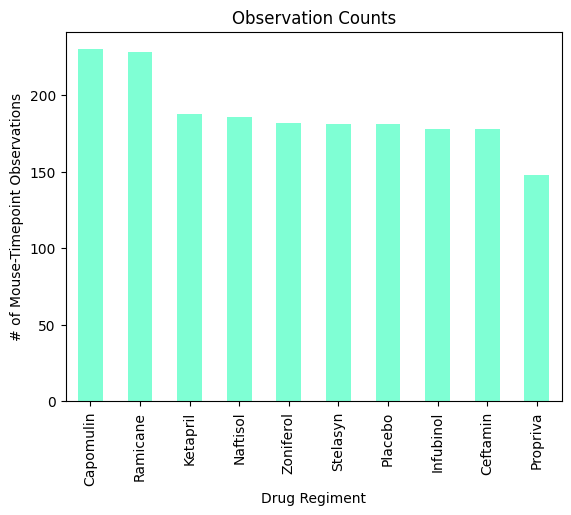

In [14]:
# Bar plot in pandas showing number of observations per drug run .plot
obs = pd.Series(clean_mouse_study_df["Drug Regimen"].value_counts())
obs.plot(x = obs.index,
         y = obs.count,
         kind = "bar",
         xlabel = "Drug Regiment",
         ylabel = "# of Mouse-Timepoint Observations",
         title = "Observation Counts",
         color = "aquamarine")


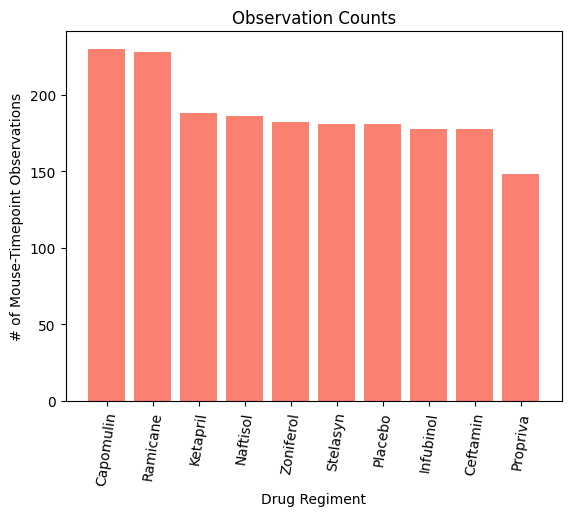

In [15]:
# Bar plot in pyplot showing number of observations per drug run plt.bar
plt.bar(obs.index, obs.values, align = "center", color = "salmon")
# Title, xlabel, ylabel, legend, and orientation
plt.title("Observation Counts")
plt.xlabel("Drug Regiment")
plt.xticks(rotation = 82, ha = "center")
plt.ylabel("# of Mouse-Timepoint Observations")

# finished product plt.show
plt.show()

<Axes: title={'center': 'Distribution of Female & Male Mice'}, ylabel='count'>

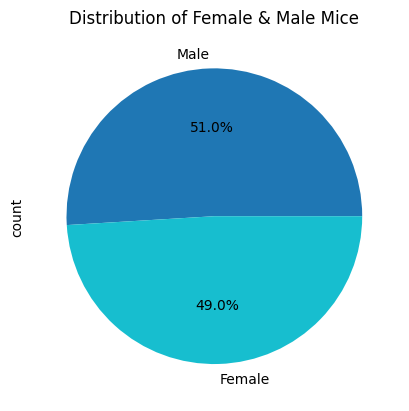

In [16]:
# pie chart with pandas
obs_sex = pd.Series(clean_mouse_study_df["Sex"].value_counts())
obs_sex.plot.pie(title = "Distribution of Female & Male Mice",labels = obs_sex.index, autopct = "%1.1f%%", cmap = "tab10")

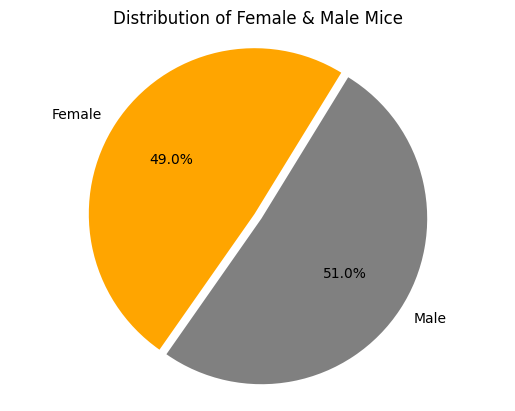

In [17]:
# pie chart with pyplots
explode = [0.05,0]
colors = ["gray","orange"]
plt.pie(obs_sex, labels = obs_sex.index, autopct= "%1.1f%%", startangle= 235, explode = explode, colors = colors)
plt.axis('equal')
plt.title('Distribution of Female & Male Mice')
plt.show()

In [18]:
# Final tumor volume for Capomulin, Ramicane, Infubinol, and Ceftamin, selecting and subsetting for those treatments, reset index to retain initial
chosen_4 = clean_mouse_study_df.set_index("Drug Regimen").loc[["Capomulin","Ramicane","Infubinol","Ceftamin"]].reset_index()
# using pd.idxmax to find max timepoints for each mouse ID
chosen_4_endpoints = chosen_4.groupby("Mouse ID")["Timepoint"].idxmax()
# subset chosen 4 based on endpoints selected, merge was doing weird things
subset_chosen_4_endpoints = chosen_4.loc[chosen_4_endpoints]
subset_chosen_4_endpoints

,Drug Regimen,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Sex,Age_months,Weight (g)
572,Infubinol,a203,45,67.973419,2,Female,20,23
534,Infubinol,a251,45,65.525743,1,Female,21,25
766,Ceftamin,a275,45,62.999356,3,Female,20,28
264,Ramicane,a411,45,38.407618,1,Male,3,22
274,Ramicane,a444,45,43.047543,0,Female,10,25
...,...,...,...,...,...,...,...,...
706,Ceftamin,y769,45,68.594745,4,Female,6,27
151,Capomulin,y793,45,31.896238,2,Male,17,17
696,Ceftamin,y865,45,64.729837,3,Male,23,26
430,Ramicane,z578,45,30.638696,0,Male,11,16


In [81]:
# put treatments into a list for for loop (and later for plot labels)
chosen_4_drugs = ["Capomulin","Ramicane","Infubinol","Ceftamin"]
# changed from list to dict, such that the drug name acts as a key, not sure if that will mess up the plot
tumor_vol = {}
# upper and lower quartiles + iqr calc
q1 = round(subset_chosen_4_endpoints["Tumor Volume (mm3)"].quantile(0.25),3)
q3 = round(subset_chosen_4_endpoints["Tumor Volume (mm3)"].quantile(0.75),3)
iqr = round(q3-q1,3)

print(f"Lower Quarter:", q1,"-- Upper Quarter:", q3,"-- IQR:", iqr)

Lower Quarter: 37.188 -- Upper Quarter: 59.93 -- IQR: 22.742


In [82]:
# Locate the rows which contain mice on each drug and get the tumor volumes, tumor_vol changed to dict
for drug in chosen_4_drugs:
    for index, row in subset_chosen_4_endpoints.iterrows():
        if row["Drug Regimen"] == drug:
            tumor_vol.setdefault(drug, []).append(row["Tumor Volume (mm3)"]) # append drug name as list to tumor_vol dict            
tumor_vol_df = pd.DataFrame(tumor_vol)  

# define function for upper and lower calc, and then apply func in for
def calculate_bounds(drug_type):
    q1 = drug_type.quantile(0.25)
    q3 = drug_type.quantile(0.75)
    iqr = q3 - q1
    # add rounding
    lower_bound = round(q1 - 1.5 * iqr,3)
    upper_bound = round(q3 + 1.5 * iqr,3)
    return upper_bound, lower_bound

# calculate bounds for each using for loop
bounds = {}
for col in tumor_vol_df.columns:
        bounds[col] = calculate_bounds(tumor_vol_df[col])

# determine outliers for each
outliers = {}
for col in tumor_vol_df.columns:
        upper_bound, lower_bound = bounds[col]
        outliers[col] = tumor_vol_df[(tumor_vol_df[col] > upper_bound) | (tumor_vol_df[col] < lower_bound)]

# print loop for upper and lower bounds
print(f"Upper and Lower Bounds for Each Drug:")
for col, (upper, lower) in bounds.items():
    print(f"{col}: Upper Bound = {upper}, Lower Bound = {lower}")

# print loop for outliers, if outlier key is not empty
print(f"-"*45)
print(f"Outliers:")
for col, outlier_df in outliers.items():
    if not outlier_df.empty:
        print(f"{col}")
        print(outlier_df)

Upper and Lower Bounds for Each Drug:
Capomulin: Upper Bound = 51.832, Lower Bound = 20.705
Ramicane: Upper Bound = 54.307, Lower Bound = 17.913
Infubinol: Upper Bound = 82.741, Lower Bound = 36.833
Ceftamin: Upper Bound = 87.666, Lower Bound = 25.355
---------------------------------------------
Outliers:
Infubinol
   Capomulin   Ramicane  Infubinol   Ceftamin
5  47.685963  33.397653  36.321346  47.784682


Text(0.5, 1.0, 'Chosen 4 Drug Treatment Boxplots')

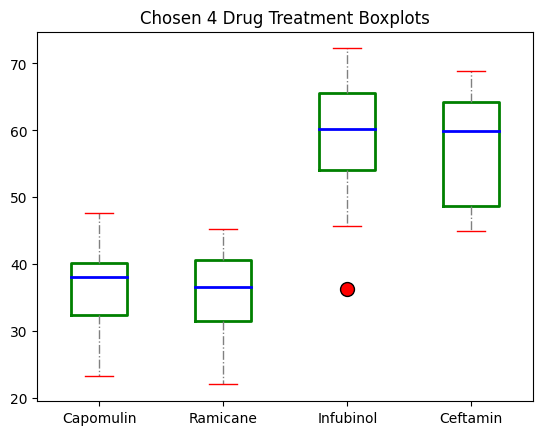

In [83]:
# boxplot for each drug type, matplotlib aes
plt.boxplot([tumor_vol_df["Capomulin"], tumor_vol_df["Ramicane"], tumor_vol_df["Infubinol"], tumor_vol_df["Ceftamin"]], 
labels = chosen_4_drugs, 
capprops={'color': 'red'}, 
whiskerprops={'color': 'gray', 'linestyle': 'dashdot'}, 
boxprops={'color': 'green', 'linewidth': 2},
medianprops={'color': 'blue', 'linewidth': 2},
flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markeredgecolor': 'black','markersize': 10}
)
plt.title("Chosen 4 Drug Treatment Boxplots")

Text(0.5, 1.0, 'Capomulin treatment of mouse l509')

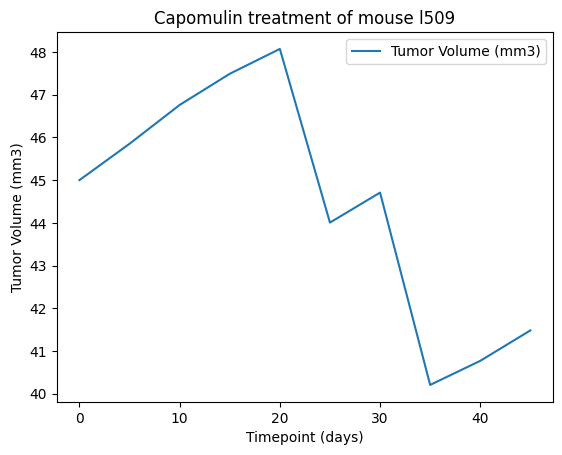

In [22]:
#line plot for mouse l509, treated with Capomulin
l509 = chosen_4[chosen_4["Mouse ID"] == "l509"]
l509.plot(x = "Timepoint", y = "Tumor Volume (mm3)")
plt.xlabel('Timepoint (days)')
plt.ylabel('Tumor Volume (mm3)')
plt.title('Capomulin treatment of mouse l509')

Text(0, 0.5, 'Average Tumor Volume (mm3)')

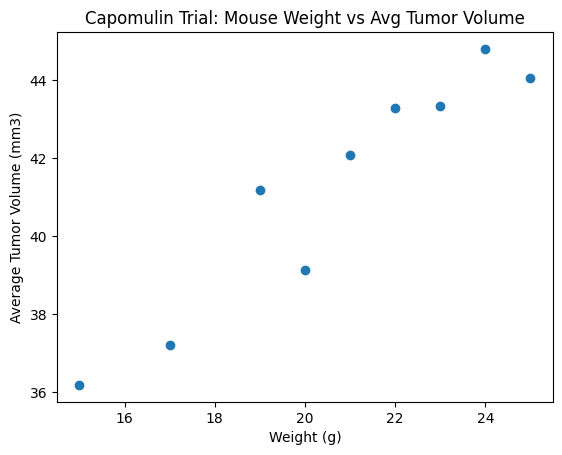

In [23]:
# scatter plot of mouse weight vs. average observed tumor volume for the Capomulin regimen
capo = pd.DataFrame(clean_mouse_study_df.loc[clean_mouse_study_df["Drug Regimen"] == "Capomulin"])
capomulin_weight = pd.DataFrame(clean_mouse_study_df.loc[clean_mouse_study_df["Drug Regimen"] == "Capomulin"].groupby("Weight (g)")["Tumor Volume (mm3)"].mean())

plt.scatter(capomulin_weight.index,capomulin_weight["Tumor Volume (mm3)"])
plt.title("Capomulin Trial: Mouse Weight vs Avg Tumor Volume")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")

Text(0, 0.5, 'Tumor Volume (mm3)')

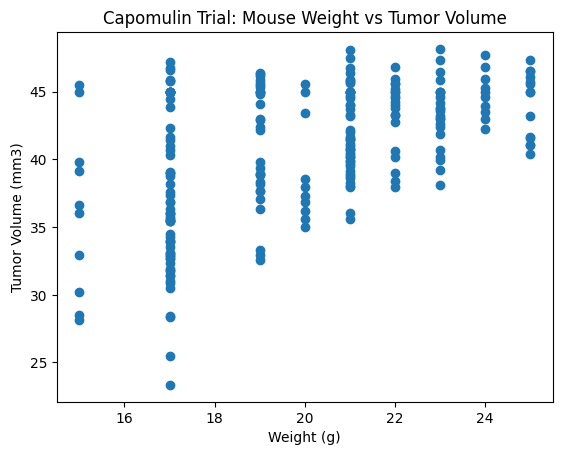

In [24]:
# take 2, using pd.merge handles
capo_c = clean_mouse_study_df.loc[clean_mouse_study_df["Drug Regimen"] == "Capomulin"].groupby("Mouse ID")["Weight (g)"].mean()
capo_det = pd.merge(capo_c,clean_mouse_study_df, how = "inner", on = ["Mouse ID", "Mouse ID"])
plt.scatter(capo_det["Weight (g)_x"],capo_det["Tumor Volume (mm3)"])
plt.title("Capomulin Trial: Mouse Weight vs Tumor Volume")
plt.xlabel("Weight (g)")
plt.ylabel("Tumor Volume (mm3)")

Text(0, 0.5, 'Tumor Volume (mm3)')

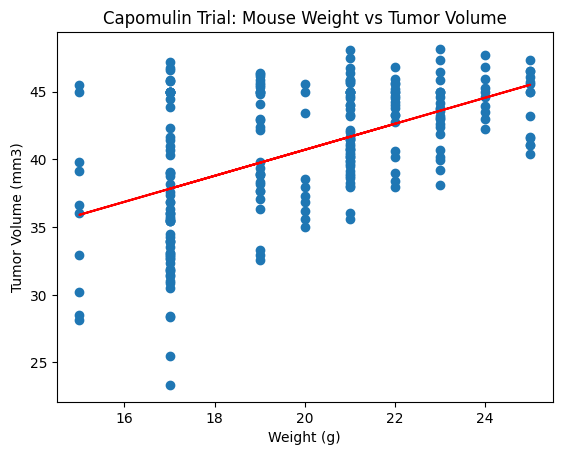

In [25]:
# add simple linear regression
slr = stats.pearsonr(capo_det["Weight (g)_x"],capo_det["Tumor Volume (mm3)"])
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(capo_det["Weight (g)_x"],capo_det["Tumor Volume (mm3)"])
slr_values = capo_det["Weight (g)_x"] * slope + intercept

plt.scatter(capo_det["Weight (g)_x"],capo_det["Tumor Volume (mm3)"])
plt.plot(capo_det["Weight (g)_x"], slr_values, "r-")
plt.title("Capomulin Trial: Mouse Weight vs Tumor Volume")
plt.xlabel("Weight (g)")
plt.ylabel("Tumor Volume (mm3)")


In [86]:
print(f"SLR correlation is: ", round(slr[0],3))
print(f"B_0 is: ", round(intercept,2), " and B_1 is: ", round(slope,2))

SLR correlation is:  0.526
B_0 is:  21.49  and B_1 is:  0.96


In [80]:
import seaborn as sea
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

# Final tumor volume for Capomulin, Placebo
placebo_comp = clean_mouse_study_df.set_index("Drug Regimen").loc[["Capomulin","Placebo"]].reset_index()
# using pd.idxmax to find max timepoints for each mouse ID
placebo_comp_endpoints = placebo_comp.groupby("Mouse ID")["Timepoint"].idxmax()
subset_placebo_comp_endpoints = placebo_comp.loc[placebo_comp_endpoints]

# replace categorical names in drug regimen and sex
le = LabelEncoder()

# Fit and transform the labels to numeric values
# Capo = 0, Placebo = 1
numeric_labels_drug = le.fit_transform(subset_placebo_comp_endpoints["Drug Regimen"])
# Female = 0, Male = 1
numeric_labels_sex = le.fit_transform(subset_placebo_comp_endpoints["Sex"])

# append numeric encode
subset_placebo_comp_endpoints["Drug_Enc"] = numeric_labels_drug
subset_placebo_comp_endpoints["Sex_Enc"] = numeric_labels_sex

#drop for corr matrix
subset_placebo_comp_endpoints = subset_placebo_comp_endpoints.drop(columns=['Drug Regimen','Mouse ID','Timepoint','Sex'])

# mod fit separation for lm
X = subset_placebo_comp_endpoints[['Drug_Enc','Sex_Enc','Weight (g)','Age_months']]
Y = subset_placebo_comp_endpoints["Tumor Volume (mm3)"]

model = LinearRegression()
model.fit(X,Y)

print("Coefficient order 'Drug_Enc','Sex_Enc','Weight (g)','Age_months':", (model.coef_,))
print("Intercept:", model.intercept_)

Coefficient order 'Drug_Enc','Sex_Enc','Weight (g)','Age_months': (array([ 1.60527051e+01, -1.79593895e+00,  9.84173311e-01,  1.93782778e-03]),)
Intercept: 17.700844301867654


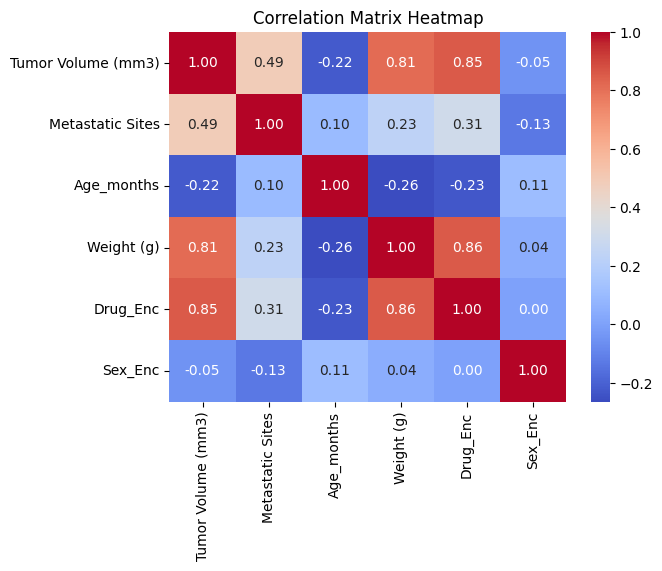

In [77]:
# seaborn correlation matrix, weigh v. tumor outputs are different from scipy lmao
corr_matrix = subset_placebo_comp_endpoints.corr()
sea.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()